<a href="https://colab.research.google.com/github/sanker1208/project/blob/main/AI_06_%EC%8B%A0%EC%A7%80%ED%95%9C_section3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [48]:
!pip install xmltodict

In [49]:
import pandas as pd
import json
from urllib.request import urlopen
from urllib.parse import urlencode, unquote, quote_plus
import urllib
import xmltodict
from datetime import datetime,timedelta
import numpy as np
import plotly.graph_objs as go
import plotly.offline as py
import matplotlib.pyplot as plt
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, add_changepoints_to_plot
from keras.models import Sequential
from keras.layers import SimpleRNN, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import math
import pickle

In [50]:
yesterday = datetime.today() - timedelta(1)
yesterday_str =  yesterday.strftime("%Y%m%d")
yesterday_str

'20211011'

In [51]:
import requests

url = 'http://openapi.data.go.kr/openapi/service/rest/Covid19/getCovid19InfStateJson'
api_key = 'tKlv0N/pkogAco/+LNbdD563C2bdPx4XMDT4lNlVZcAhwQQr17gmyq4GGGVQYZGB3UH18hJ8SDjfYPkud/PzTA=='
# api_key_encode = 'tKlv0N%2FpkogAco%2F%2BLNbdD563C2bdPx4XMDT4lNlVZcAhwQQr17gmyq4GGGVQYZGB3UH18hJ8SDjfYPkud%2FPzTA%3D%3D'

params = {
    'serviceKey' : api_key,
    'pageNo' : '1',
    'numOfRows' : '999',
    'startCreateDt' : '20200120',
    'endCreateDt' : yesterday_str
    }

response = requests.get(url, params=params)
print(response.content)

b'<?xml version="1.0" encoding="UTF-8" standalone="yes"?><response><header><resultCode>00</resultCode><resultMsg>NORMAL SERVICE.</resultMsg></header><body><items><item><accDefRate>2.4254766583</accDefRate><accExamCnt>14977419</accExamCnt><accExamCompCnt>13721674</accExamCompCnt><careCnt>32211</careCnt><clearCnt>298022</clearCnt><createDt>2021-10-11 09:36:36.635</createDt><deathCnt>2583</deathCnt><decideCnt>332816</decideCnt><examCnt>1255745</examCnt><resutlNegCnt>13388858</resutlNegCnt><seq>662</seq><stateDt>20211011</stateDt><stateTime>00:00</stateTime><updateDt>null</updateDt></item><item><accDefRate>2.4216238690</accDefRate><accExamCnt>14951658</accExamCnt><accExamCompCnt>13689946</accExamCompCnt><careCnt>32236</careCnt><clearCnt>296708</clearCnt><createDt>2021-10-10 09:40:09.109</createDt><deathCnt>2575</deathCnt><decideCnt>331519</decideCnt><examCnt>1261712</examCnt><resutlNegCnt>13358427</resutlNegCnt><seq>661</seq><stateDt>20211010</stateDt><stateTime>00:00</stateTime><updateDt>

In [52]:
result = response.content
jsonString = json.dumps(xmltodict.parse(result), indent = 4)
jsonString = jsonString.replace('accDefRate', '누적 확진률').replace('accExamCnt', '누적 검사수').replace('accExamCompCnt', '누적검사 완료수').replace('careCnt', '치료중 환자 수').replace('clearCnt', '격리해제 수').replace('createDt', '등록일시분초').replace('deathCnt', '사망자 수').replace('decideCnt', '확진자 수').replace('examCnt', '검사진행 수').replace('resutlNegCnt', '결과 음성 수').replace('examCnt', '검사진행 수').replace('seq', '게시글번호(감염현황 고유값)').replace('stateDt', '기준일').replace('stateTime', '기준시간').replace('updateDt', '수정일시분초')

print(jsonString)

{
    "response": {
        "header": {
            "resultCode": "00",
            "resultMsg": "NORMAL SERVICE."
        },
        "body": {
            "items": {
                "item": [
                    {
                        "누적 확진률": "2.4254766583",
                        "누적 검사수": "14977419",
                        "누적검사 완료수": "13721674",
                        "치료중 환자 수": "32211",
                        "격리해제 수": "298022",
                        "등록일시분초": "2021-10-11 09:36:36.635",
                        "사망자 수": "2583",
                        "확진자 수": "332816",
                        "검사진행 수": "1255745",
                        "결과 음성 수": "13388858",
                        "게시글번호(감염현황 고유값)": "662",
                        "기준일": "20211011",
                        "기준시간": "00:00",
                        "수정일시분초": "null"
                    },
                    {
                        "누적 확진률": "2.4216238690",
                        "누적 검사수": "14951658",

In [53]:
jsonDict = json.loads(jsonString)

In [54]:
js = jsonDict["response"]['body']['items']['item']
df_raw = pd.DataFrame(js)
df_raw = df_raw.sort_index(ascending=False).reset_index(drop=True)
df_raw

,누적 확진률,누적 검사수,누적검사 완료수,치료중 환자 수,격리해제 수,등록일시분초,사망자 수,확진자 수,검사진행 수,결과 음성 수,게시글번호(감염현황 고유값),기준일,기준시간,수정일시분초
0,25,4,4,1,0,2020-01-20 17:00:00.000,0,1,0,3,1,20200120,17:00,2021-10-07 10:30:51.51
1,6.666666667,15,15,1,0,2020-01-21 09:00:00.000,0,1,0,14,2,20200121,09:00,2021-10-07 10:30:51.51
2,4.761904762,21,21,1,0,2020-01-22 12:00:00.000,0,1,0,20,3,20200122,12:00,2021-10-07 10:30:51.51
3,4,25,25,1,0,2020-01-23 09:00:00.000,0,1,0,24,4,20200123,09:00,2021-10-07 10:30:51.51
4,6.896551724,29,29,2,0,2020-01-24 00:00:00.000,0,2,0,27,5,20200124,00:00,2021-10-07 10:30:51.51
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
624,2.3845480882,14780945,13561144,33796,287040,2021-10-06 09:49:43.197,2536,323372,1219801,13237772,657,20211006,00:00,2021-10-09 09:48:47.854
625,2.3965827857,14833972,13594231,34431,288822,2021-10-07 09:48:27.592,2544,325797,1239741,13268434,658,20211007,00:00,2021-10-09 09:48:08.839
626,2.4028412800,14882198,13649341,33327,292091,2021-10-08 09:46:59.694,2554,327972,1232857,13321369,659,20211008,00:00,2021-10-09 09:44:05.254
627,2.4216238690,14951658,13689946,32236,296708,2021-10-10 09:40:09.109,2575,331519,1261712,13358427,661,20211010,00:00,null


In [55]:
# numeric_col = df_raw.columns.drop(['createDt', 'stateDt','stateTime', 'updateDt'])
# df_raw[numeric_col] = df_raw[numeric_col].apply(pd.to_numeric)

In [56]:
df_raw.dtypes

누적 확진률             object
누적 검사수             object
누적검사 완료수           object
치료중 환자 수           object
격리해제 수             object
등록일시분초             object
사망자 수              object
확진자 수              object
검사진행 수             object
결과 음성 수            object
게시글번호(감염현황 고유값)    object
기준일                object
기준시간               object
수정일시분초             object
dtype: object

In [57]:
# df_raw['createDt'] = pd.to_datetime(df_raw['createDt'])
# df_raw

In [58]:
# df_raw = df_raw.sort_index(ascending=False).reset_index(drop=True)
# df_raw['dayCnt'] = abs(df_raw['decideCnt'].diff())
# df_raw = df_raw.sort_index(ascending=False).reset_index(drop=True)
# df['dayCnt'].iloc[0] = 1.0
# df_raw

In [59]:
# from google.colab import files

# with pd.ExcelWriter('df_raw.xlsx') as writer: 

#   df_raw.to_excel(writer, sheet_name='1')

# files.download('df_raw.xlsx')

In [60]:
df = df_raw.copy()

df['기준일'] = pd.to_datetime(df['기준일'])
df = df[['기준일', '확진자 수']]
df['확진자 수'] = df['확진자 수'].apply(pd.to_numeric)

In [61]:
df['일일확진자 수'] = abs(df['확진자 수'].diff())
df = df.loc[1:]
df = df.sort_index(ascending=False).reset_index(drop=True)
df['일일확진자 수'].iloc[0] = 1.0
# df.set_index('기준일', inplace=True)
df.drop(['확진자 수'], axis=1, inplace=True)
df

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,기준일,일일확진자 수
0,2021-10-11,1.0
1,2021-10-10,3547.0
2,2021-10-08,2175.0
3,2021-10-07,2425.0
4,2021-10-06,2027.0
...,...,...
623,2020-01-25,0.0
624,2020-01-24,1.0
625,2020-01-23,0.0
626,2020-01-22,0.0


In [62]:
fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x = df['기준일'],
        y = df['일일확진자 수'],
        name = '일일확진자 그래프'
    )
)

In [63]:
df_prophet = df.copy()
df_prophet = df_prophet.rename(columns={
    '기준일' : 'ds',
    '일일확진자 수' : 'y'
})

In [64]:
model = Prophet(
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True,
    seasonality_mode='additive'
)

model.fit(df_prophet)

future = model.make_future_dataframe(periods=7)
future.tail(7)

,ds
627,2021-10-12
628,2021-10-13
629,2021-10-14
630,2021-10-15
631,2021-10-16
632,2021-10-17
633,2021-10-18


In [65]:
forecast = model.predict(future)

forecast

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2020-01-21,18.479226,-262.186887,335.297399,18.479226,18.479226,-3.509084,-3.509084,-3.509084,74.122945,74.122945,74.122945,-77.632029,-77.632029,-77.632029,0.0,0.0,0.0,14.970141
1,2020-01-22,18.295661,-148.646844,434.466878,18.295661,18.295661,127.230081,127.230081,127.230081,74.122945,74.122945,74.122945,53.107136,53.107136,53.107136,0.0,0.0,0.0,145.525742
2,2020-01-23,18.112097,-149.131152,419.833269,18.112097,18.112097,118.540721,118.540721,118.540721,74.122945,74.122945,74.122945,44.417776,44.417776,44.417776,0.0,0.0,0.0,136.652818
3,2020-01-24,17.928532,-157.266001,391.222959,17.928532,17.928532,108.788788,108.788788,108.788788,74.122945,74.122945,74.122945,34.665843,34.665843,34.665843,0.0,0.0,0.0,126.717320
4,2020-01-25,17.744968,-169.232282,418.158891,17.744968,17.744968,117.485205,117.485205,117.485205,74.122945,74.122945,74.122945,43.362260,43.362260,43.362260,0.0,0.0,0.0,135.230173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
629,2021-10-14,2259.326931,2076.718215,2676.333922,2259.326931,2259.326931,118.540721,118.540721,118.540721,74.122945,74.122945,74.122945,44.417776,44.417776,44.417776,0.0,0.0,0.0,2377.867652
630,2021-10-15,2271.936247,2093.041816,2664.689554,2271.936247,2271.936247,108.788788,108.788788,108.788788,74.122945,74.122945,74.122945,34.665843,34.665843,34.665843,0.0,0.0,0.0,2380.725035
631,2021-10-16,2284.545564,2114.396424,2692.847718,2284.545564,2284.545564,117.485205,117.485205,117.485205,74.122945,74.122945,74.122945,43.362260,43.362260,43.362260,0.0,0.0,0.0,2402.030769
632,2021-10-17,2297.154880,2078.262590,2662.269647,2297.154880,2297.166144,77.829296,77.829296,77.829296,74.122945,74.122945,74.122945,3.706351,3.706351,3.706351,0.0,0.0,0.0,2374.984176


In [66]:
forecast_db = forecast[['ds', 'trend']]
forecast_db

,ds,trend
0,2020-01-21,18.479226
1,2020-01-22,18.295661
2,2020-01-23,18.112097
3,2020-01-24,17.928532
4,2020-01-25,17.744968
...,...,...
629,2021-10-14,2259.326931
630,2021-10-15,2271.936247
631,2021-10-16,2284.545564
632,2021-10-17,2297.154880


In [67]:
fig = plot_plotly(model, forecast)
py.iplot(fig)

In [68]:
n = 30

In [69]:
model_2 = Prophet(
    changepoint_prior_scale=0.2,
    changepoint_range=0.98,
    yearly_seasonality=False,
    weekly_seasonality=True,
    daily_seasonality=True,
    seasonality_mode='additive'
)

model_2.fit(df_prophet)

future_2 = model_2.make_future_dataframe(periods=n)
forecast_2 = model_2.predict(future_2)

fig_2 = plot_plotly(model_2, forecast_2)
py.iplot(fig_2)

In [70]:
forecast_2['trend'].iloc[-1]

2407.0680665891105

In [72]:
# ㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡㅡ

# 새 섹션

In [73]:
dataset = df_raw['확진자 수'].values
dataset = dataset.astype('float32')
dataset = dataset.reshape(-1, 1)

In [74]:
scaler = MinMaxScaler(feature_range=(0,1))
Dataset = scaler.fit_transform(dataset)
train_data, test_data = train_test_split(Dataset, test_size=0.2, shuffle=False)
print(len(train_data), len(test_data))

503 126


In [75]:
# 데이터 형태 연속되는 데이터로 변경
def create_dataset(dataset, look_back):
  x_data = []
  y_data = []
  for i in range(len(dataset)-look_back):
    data = dataset[i:(i+look_back), 0]
    x_data.append(data)
    y_data.append(dataset[i+look_back, 0])
  return np.array(x_data), np.array(y_data)

In [76]:
look_back = 3
x_train, y_train = create_dataset(train_data, look_back)
x_test, y_test = create_dataset(test_data, look_back)
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(500, 3) (500,)
(123, 3) (123,)


In [77]:
X_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
X_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))
print(X_train.shape)
print(X_test.shape)

(500, 1, 3)
(123, 1, 3)


In [78]:
# SimpleRNN 사용

model_seq = Sequential()
model_seq.add(SimpleRNN(5, input_shape=(1, look_back)))
model_seq.add(Dense(1, activation='linear'))
model_seq.compile(loss='mse', optimizer='adam')
model_seq.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn (SimpleRNN)       (None, 5)                 45        
_________________________________________________________________
dense (Dense)                (None, 1)                 6         
Total params: 51
Trainable params: 51
Non-trainable params: 0
_________________________________________________________________


In [79]:
model_seq.fit(X_train, y_train, epochs=100, batch_size=1, verbose=1)

Epoch 1/100
500/500 [==============================] - 2s 1ms/step - loss: 0.0024
Epoch 2/100
500/500 [==============================] - 1s 1ms/step - loss: 6.7308e-06
Epoch 3/100
500/500 [==============================] - 1s 2ms/step - loss: 6.3468e-06
Epoch 4/100
500/500 [==============================] - 1s 1ms/step - loss: 7.3621e-06
Epoch 5/100
500/500 [==============================] - 1s 1ms/step - loss: 6.4514e-06
Epoch 6/100
500/500 [==============================] - 1s 1ms/step - loss: 7.1650e-06
Epoch 7/100
500/500 [==============================] - 1s 1ms/step - loss: 7.5405e-06
Epoch 8/100
500/500 [==============================] - 1s 1ms/step - loss: 7.3768e-06
Epoch 9/100
500/500 [==============================] - 1s 1ms/step - loss: 9.6454e-06
Epoch 10/100
500/500 [==============================] - 1s 1ms/step - loss: 7.2080e-06
Epoch 11/100
500/500 [==============================] - 1s 1ms/step - loss: 8.7583e-06
Epoch 12/100
500/500 [==============================] - 

In [80]:
train_predict = model_seq.predict(X_train)
test_predict = model_seq.predict(X_test)
train_predict_scaled = scaler.inverse_transform(train_predict)
y_train_scaled = scaler.inverse_transform([y_train])
test_predict_scaled = scaler.inverse_transform(test_predict)
y_test_scaled = scaler.inverse_transform([y_test])

In [81]:
train_score = math.sqrt(mean_squared_error(y_train_scaled[0], train_predict_scaled[:,0]))
print(f'Train Score: {train_score : .2f} RMSE')
test_score = math.sqrt(mean_squared_error(y_test_scaled[0], test_predict_scaled[:,0]))
print(f'Test Score: {test_score : .2f} RMSE')

Train Score:  452.35 RMSE
Test Score:  13529.12 RMSE


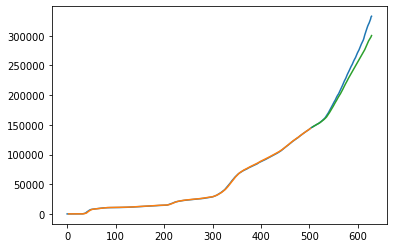

In [82]:
train_predict_plot = np.empty_like(dataset)
train_predict_plot[:,:] = np.nan
train_predict_plot[look_back:len(train_predict_scaled)+look_back, :] = train_predict_scaled

test_predict_plot = np.empty_like(dataset)
test_predict_plot[:,:] = np.nan
test_predict_plot[len(train_predict_scaled) + (look_back) * 2:len(dataset), :] = test_predict_scaled

plt.plot(dataset)
plt.plot(train_predict_plot)
plt.plot(test_predict_plot)
plt.show()

In [83]:
model_seq.save('my_model.h5')

In [84]:
# df_dataset = pd.DataFrame(dataset)
# df_train = pd.DataFrame(train_predict_scaled)
# df_test = pd.DataFrame(test_predict_scaled)

# df_dataset.shape, df_train.shape, df_test.shape 

In [85]:
# date = input('입력날짜(예: 20201231):')
# yester_date = datetime.strptime(yesterday_str, '%Y%m%d')
# future_date = datetime.strptime(date, '%Y%m%d')

# n = (future_date - yester_date).days
# print(n)

In [86]:
# train_predict_plot = np.empty(shape=(len(dataset) + n, 1))
# train_predict_plot[:,:] = np.nan
# train_predict_plot[look_back:len(train_predict_scaled)+look_back, :] = train_predict_scaled

# test_predict_plot = np.empty(shape=(len(dataset) + n, 1))
# test_predict_plot[:,:] = np.nan
# test_predict_plot[len(train_predict_scaled) + (look_back) * 2:len(dataset), :] = test_predict_scaled

# plt.plot(dataset)
# plt.plot(train_predict_plot)
# plt.plot(test_predict_plot)
# plt.show()